## Normalizing Flows to derive SFHs and metallicity from spectra

We want to infer the percentiles of stellar mass and metallicity of galaxies from their spectra (whose dimensions have been reduced using an encoder with an attention module from 4300 points to 16-component latent vectors). The goal is to train the model with synthetic data processed with the observational features, and later use it to predict the properties for observed stacks of ETGs from SDSS

We load the modules and define the format of the plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi import utils as Ut
from sbi import inference as Inference
import pickle
from tqdm import tqdm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We load the percentiles and latent vectors for the full dataset, unify all the minibatches and visualize the data

In [30]:
latents_batch=np.load('./saved_models/latents_all_etg.npy',allow_pickle=True)
percentiles=np.load('./saved_input/y_etg.npy',allow_pickle=True)
latents=np.zeros((90000,16))
batch_size=128

#to create a single dataset with all the minibatches
for j in range(len(latents_batch)):
    for i,x in enumerate(latents_batch[j]):
        latents[batch_size*j+i,:]=x
        
print(np.shape(latents))
print(np.shape(percentiles))

"""#for checking distributions
for i in range(9):
    plt.hist(percentiles[:,i],bins=20)
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    plt.show()

for i in range(16):
    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))
#plt.legend()
plt.title('latent components ')
plt.show()"""



FileNotFoundError: [Errno 2] No such file or directory: './saved_models/latents_all_ssfr.npy'

We load the shuffling indeces and create the training vectors

In [4]:
#training with the first 135.000 elements of the dataset (previously shuffled) 

index_sh=np.load('./saved_models/ind_sh_etg.npy')

latents=latents[index_sh,:]
percentiles=percentiles[index_sh,:]

x=latents[:81000,:]
theta=percentiles[:81000,:]


We define the range for the posterior estimation

In [5]:
#percentiles
lower_bounds = -2*torch.ones(np.shape(theta[0,:]))
upper_bounds = 16*torch.ones(np.shape(theta[0,:]))

#metallicity
lower_bounds[-1]=-2.5
upper_bounds[-1]=0.6



bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

We define the model and train, then save the model

In [6]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

import time

start=time.time()
# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train(learning_rate=5e-4,show_train_summary=True)
end=time.time()
qphi = anpe.build_posterior(p_theta_x_est)


print(end-start, ' s')

 Neural network successfully converged after 221 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 221
        Best validation performance: 18.5646
        -------------------------
        
26246.950839042664  s


Save posterior or load it

In [8]:
file="./saved_models/my_posterior_etg.pkl"

with open(file, "wb") as handle:
    pickle.dump(qphi, handle)

handle.close()
"""
file = open(file, 'rb')
qphi = pickle.load(file)
file.close()
"""

"\nfile = open(file, 'rb')\nqphi = pickle.load(file)\nfile.close()\n"

We create a function to see real vs predicted percentiles (we plot the mean and the interval of confidence: sigma, 2sigma... of the posteriors) for the test dataset (15.000 samples)

81709


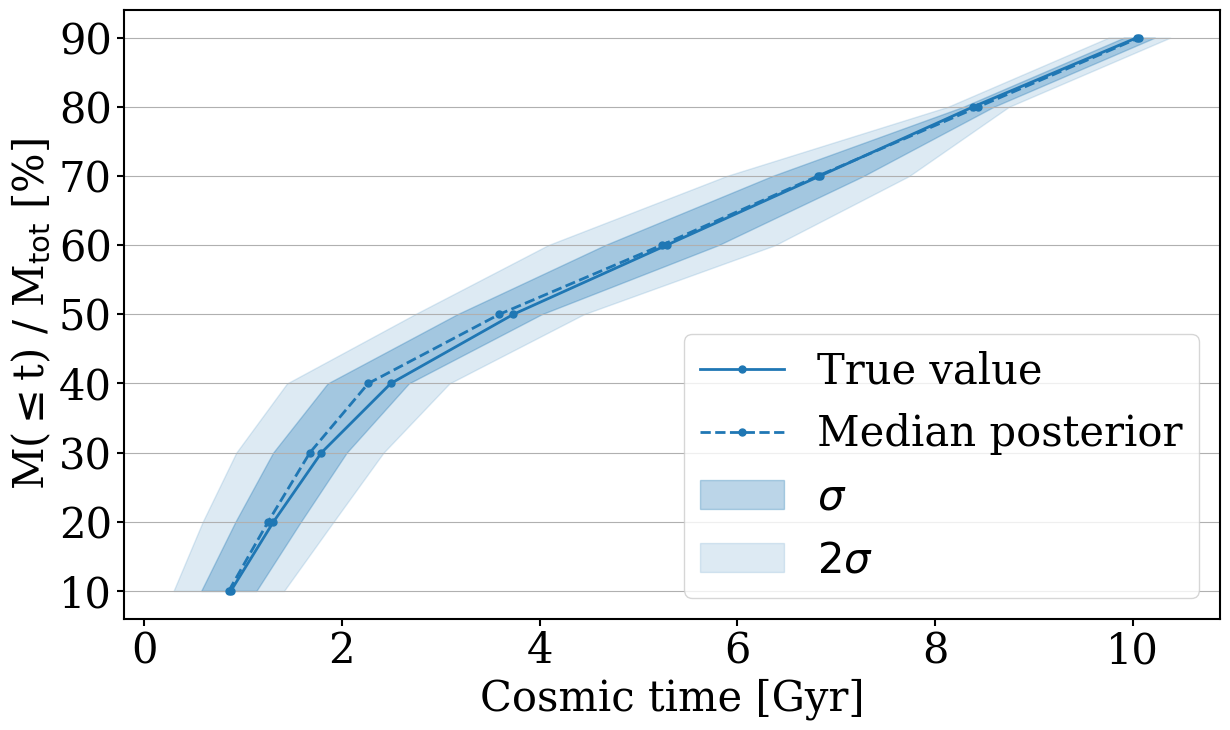

88015


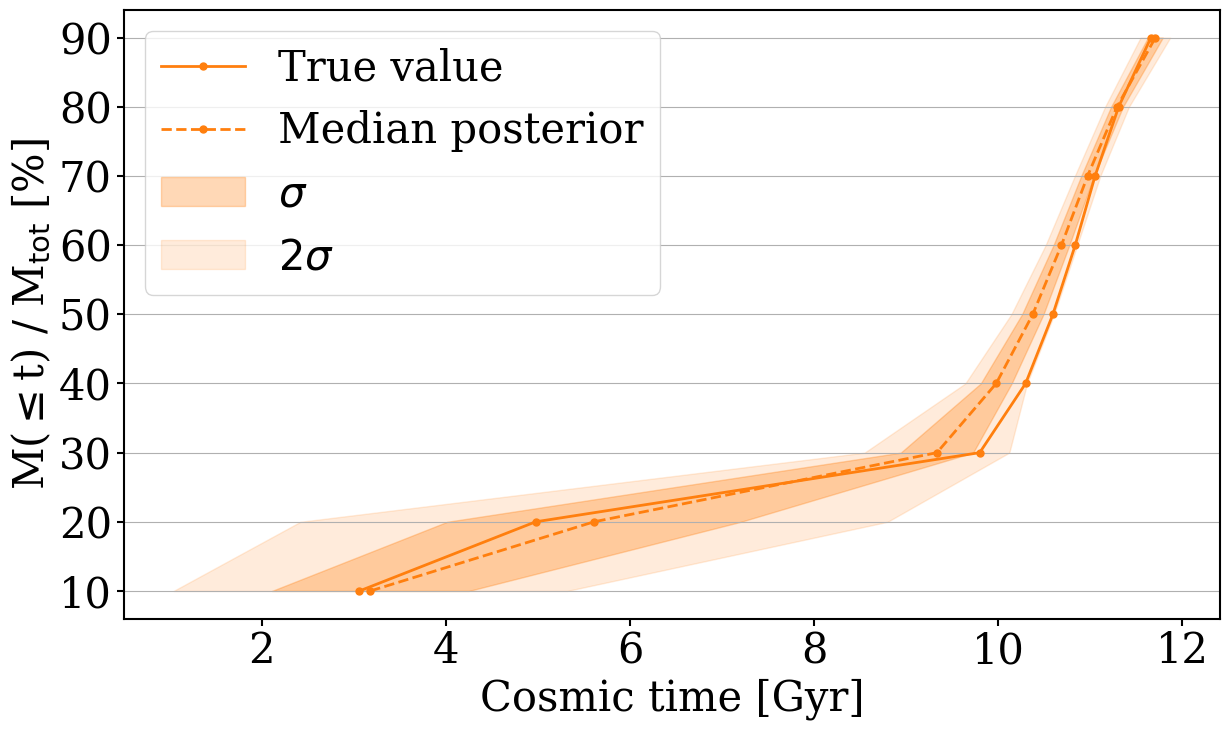

81076


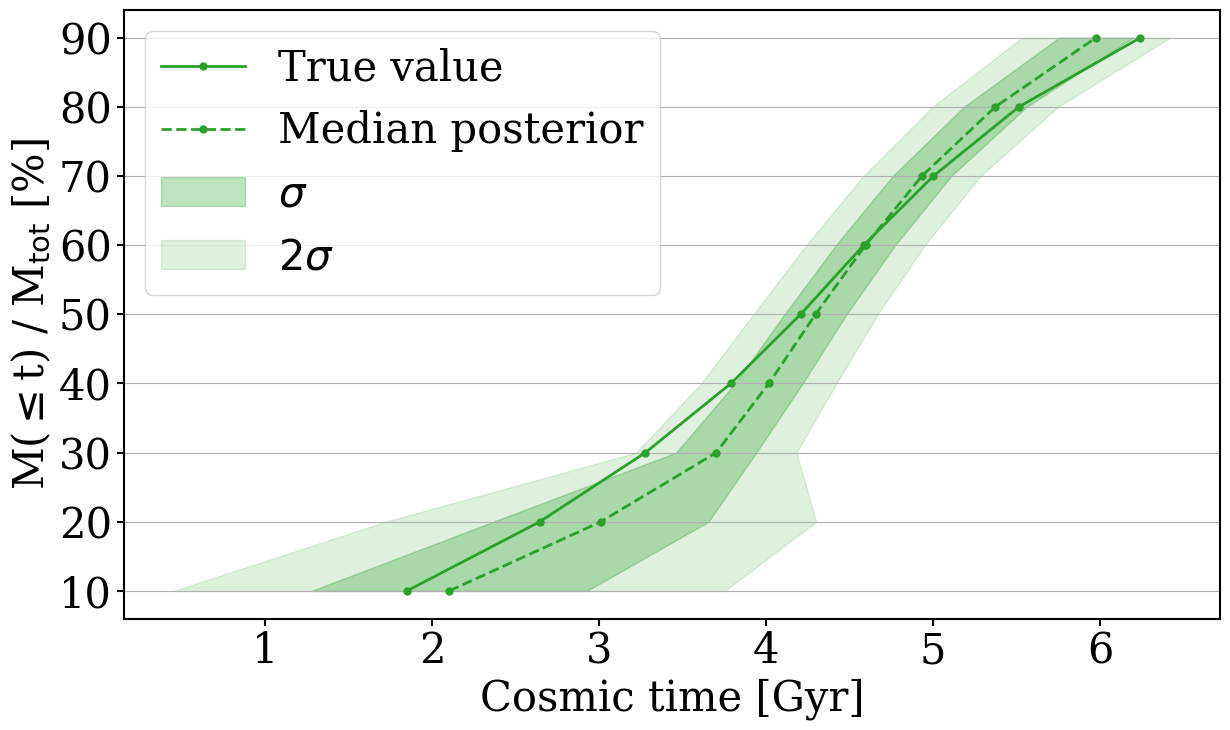

83232


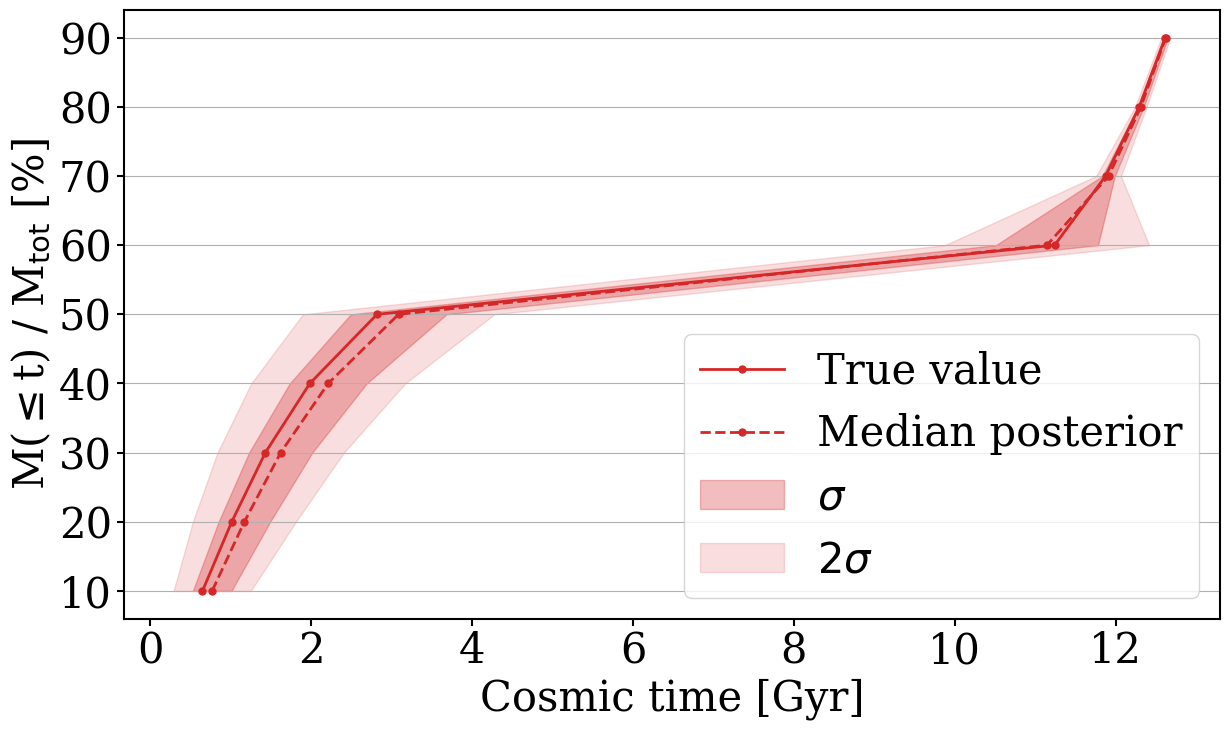

83998


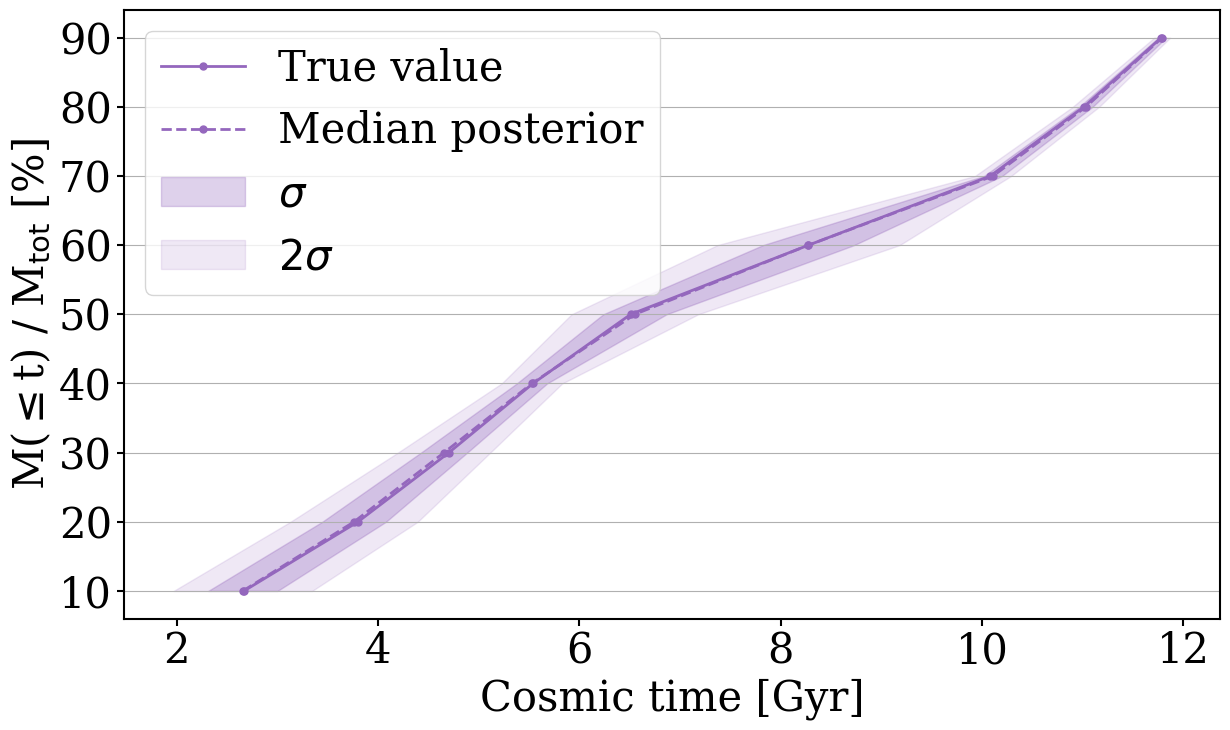

88401


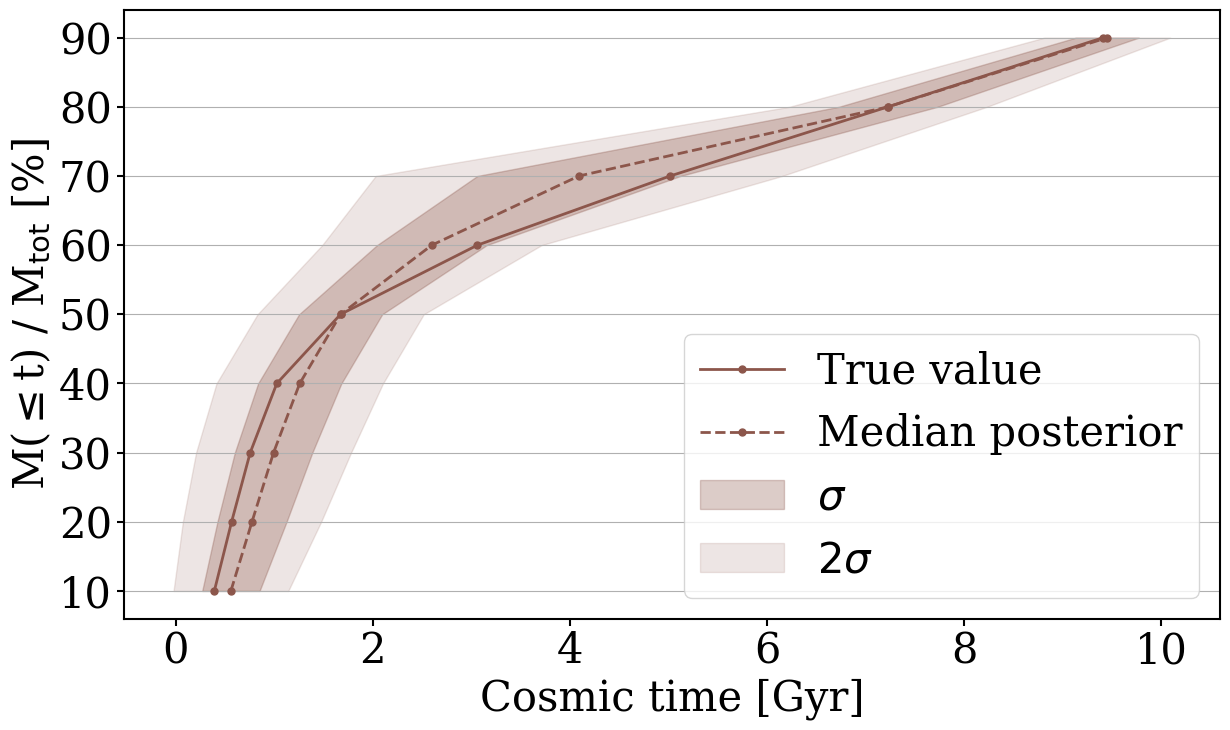

81857


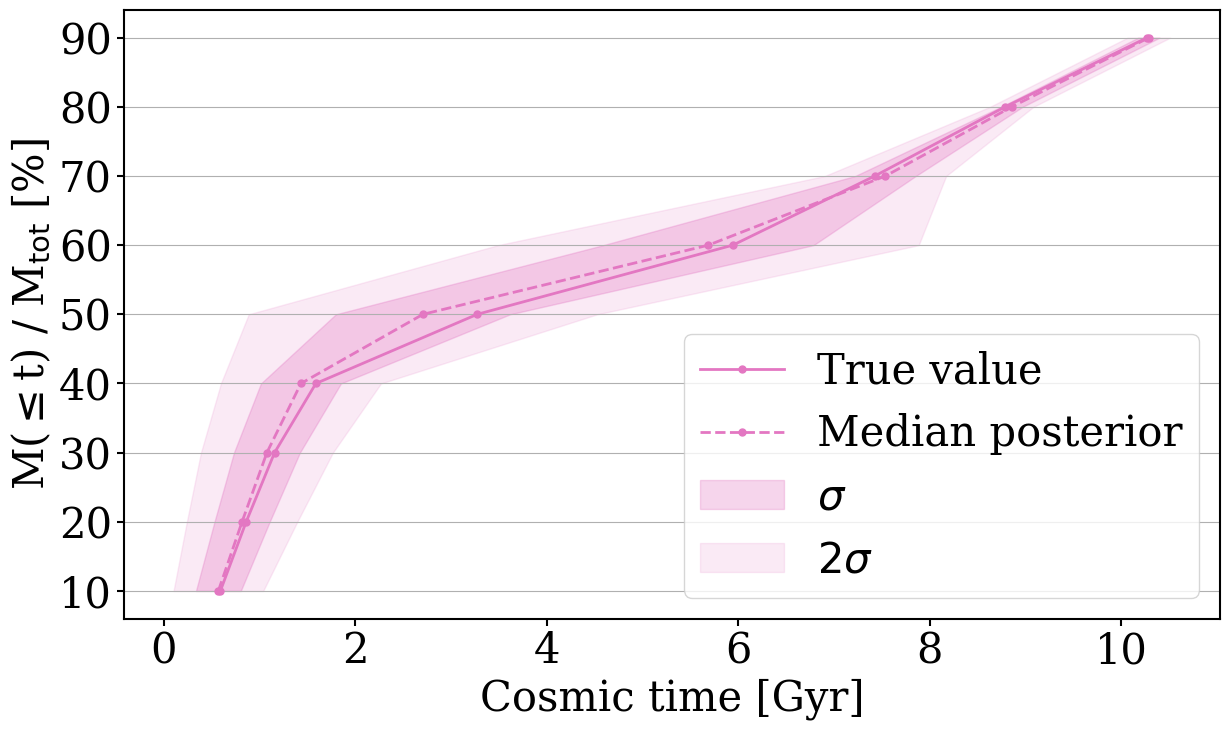

85348


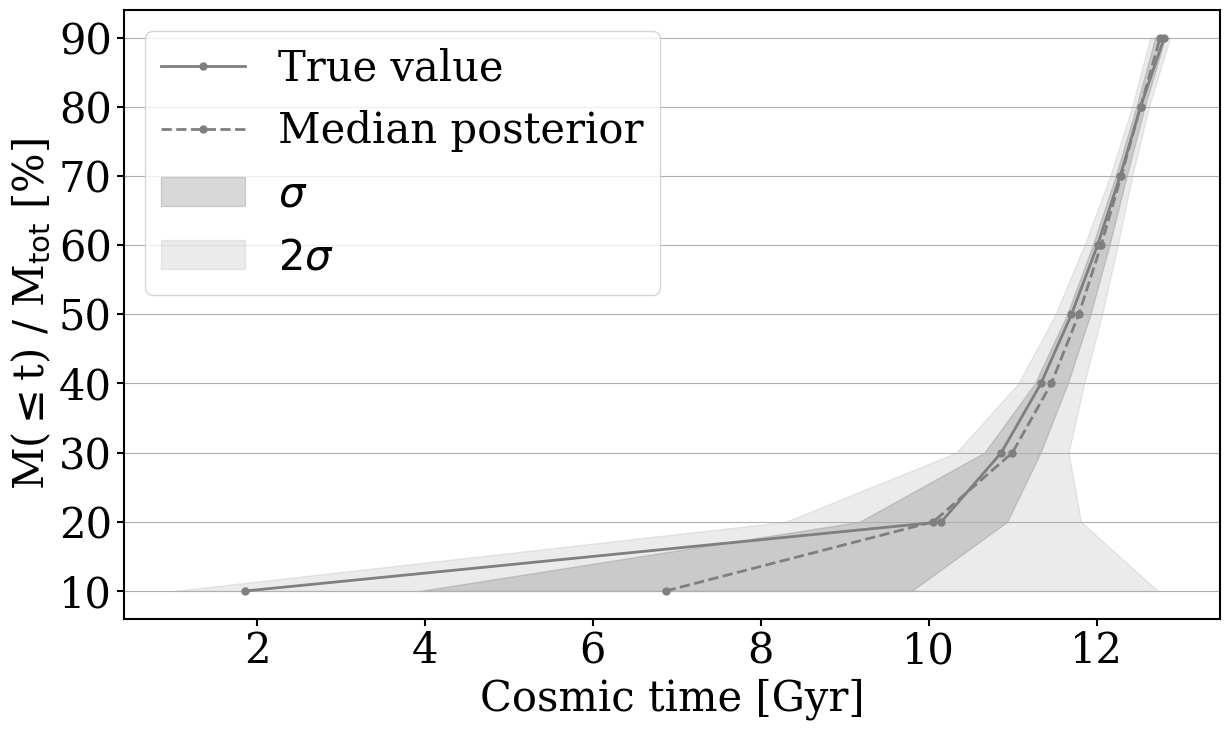

82597


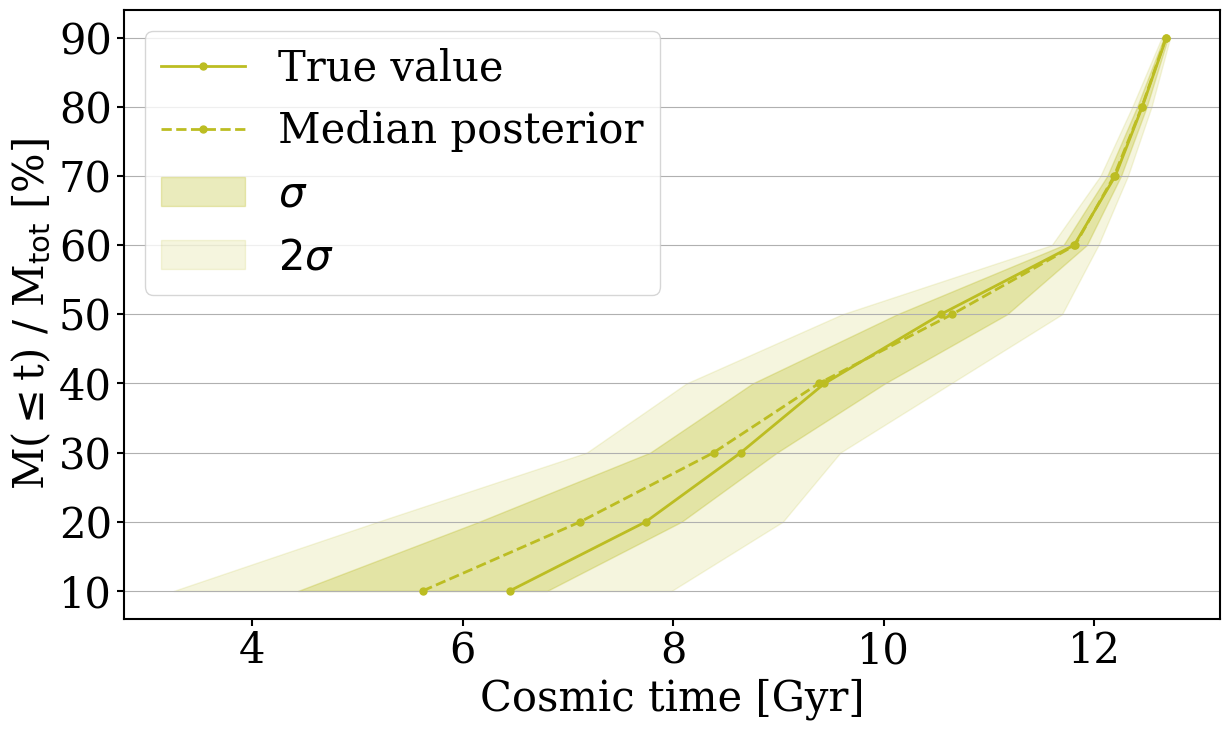

89741


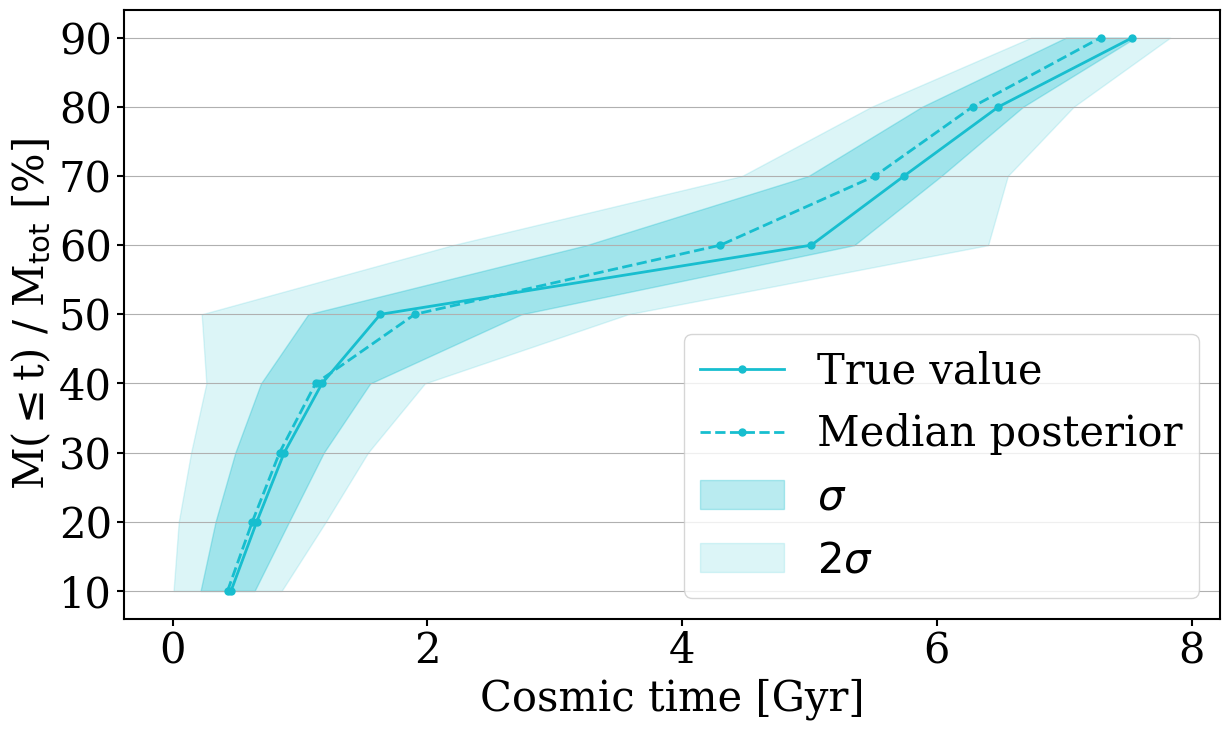

85463


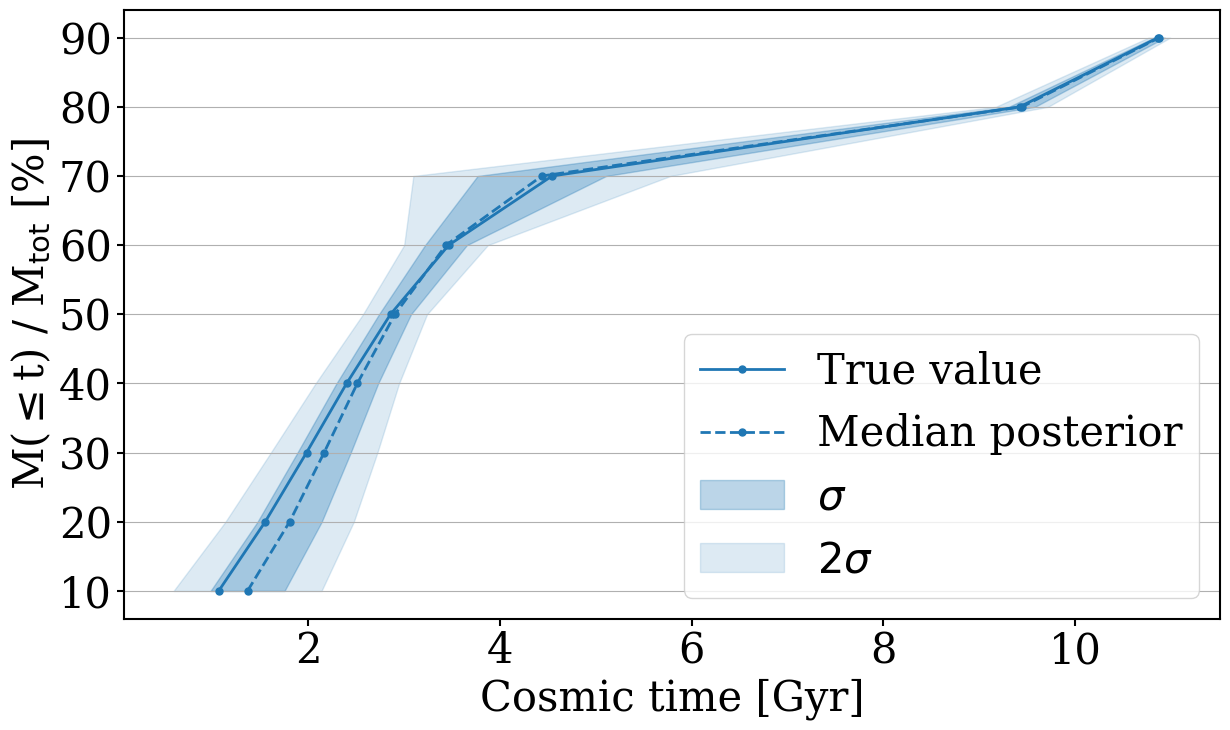

85537


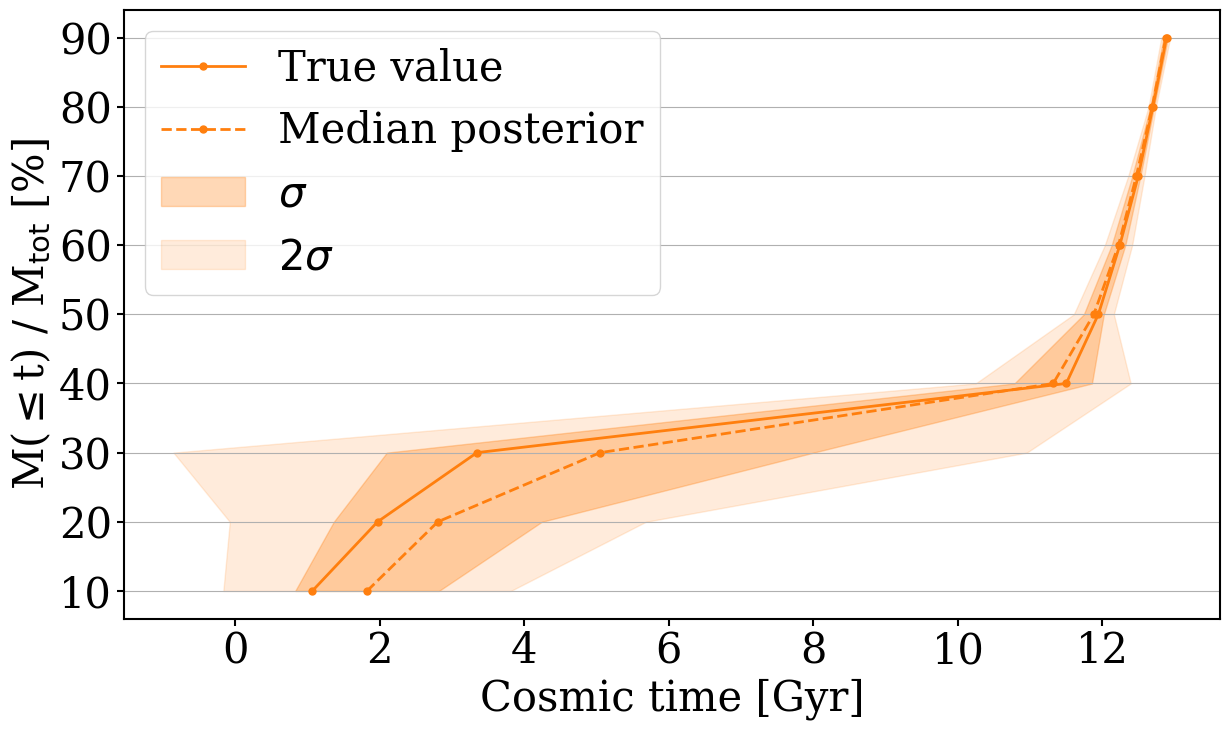

86600


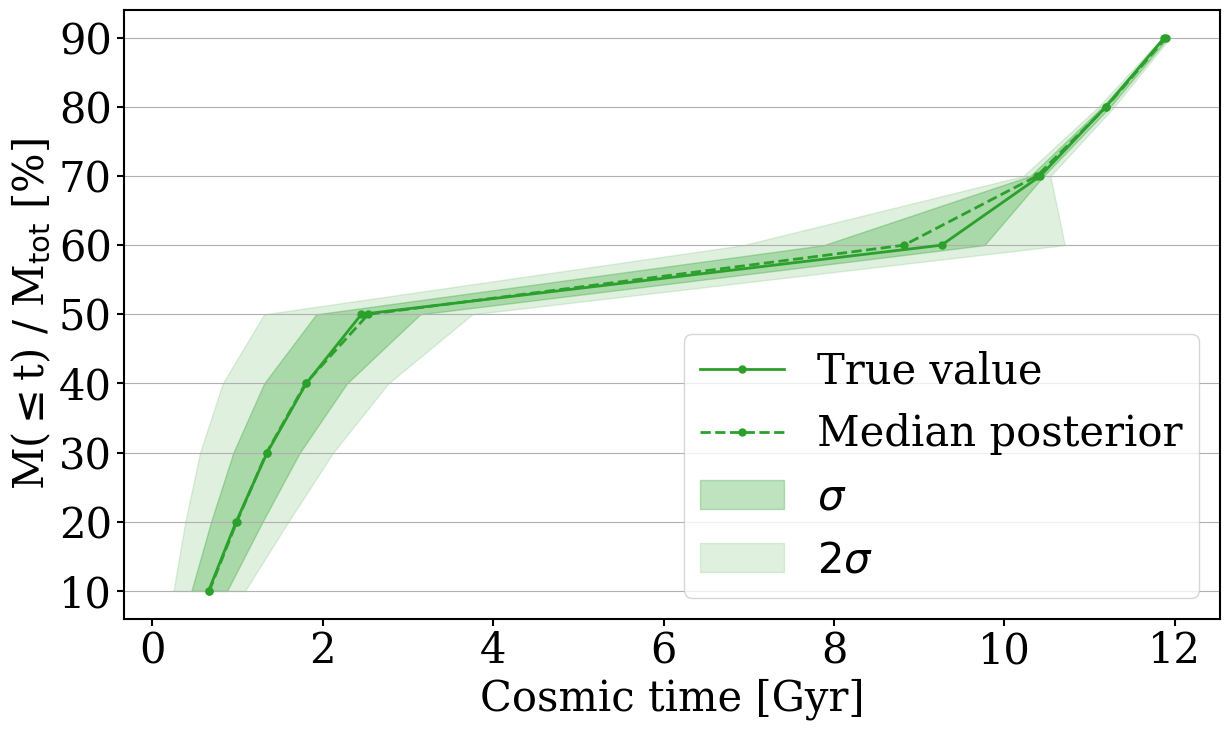

82775


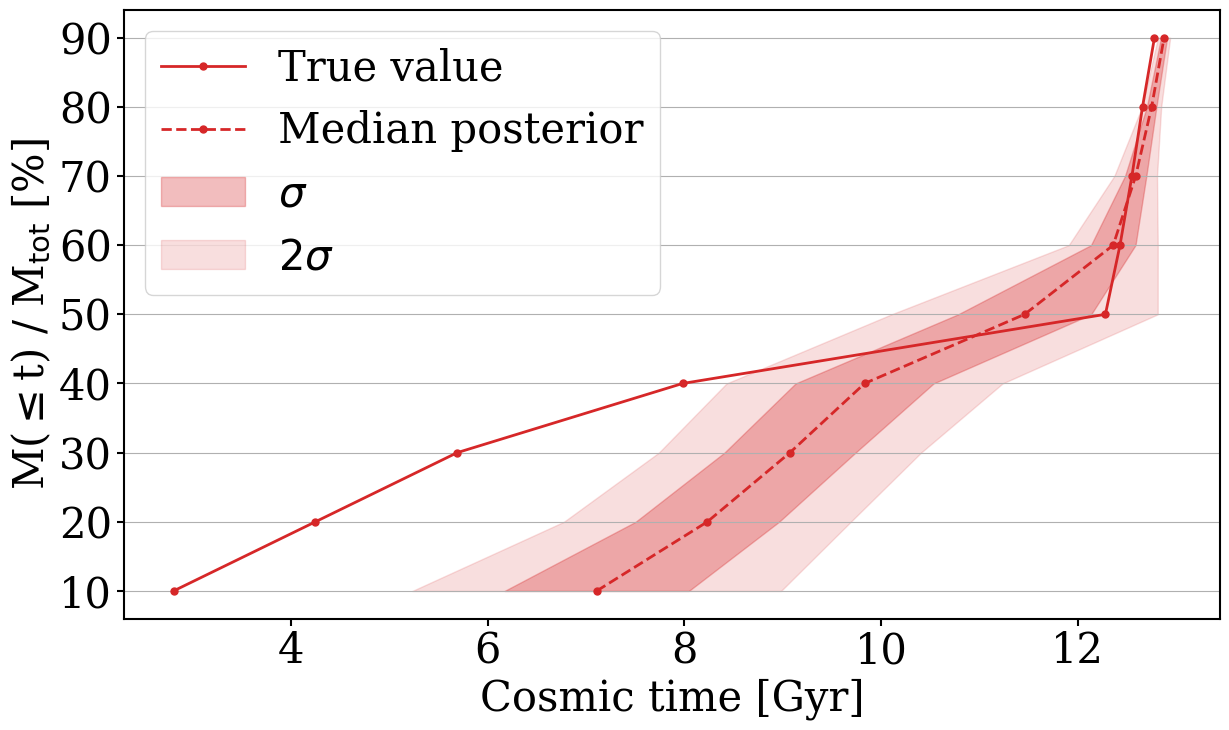

81128


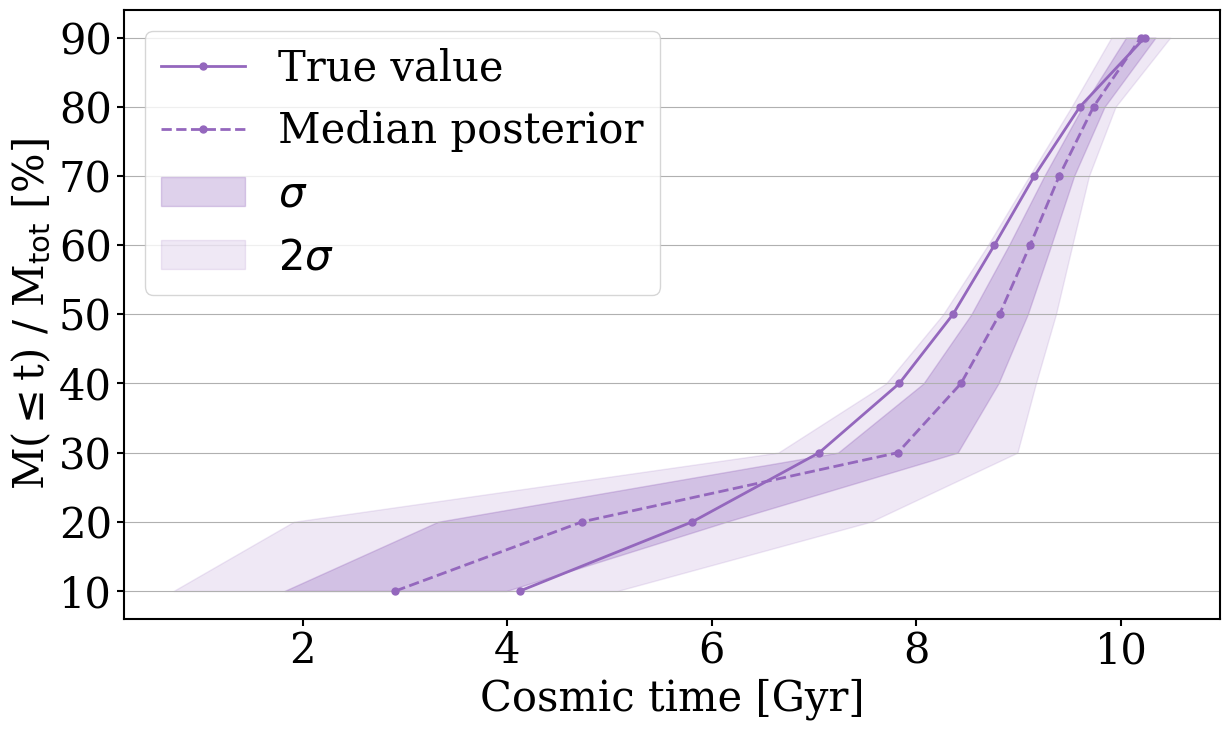

In [11]:
def plot_percentile_distribution(index_list=np.random.randint(81000,90000,15)):

    """Plot stellar mass percentiles vs cosmic time, both the real and the predicted by the model (sampling the posteriors)

        Parameters
        ----------
        index_list: array
                    Indeces from the test sample to estimate and plot the percentiles (after sampling the full dataset)
        """
    
    
    for k,j in enumerate(index_list):
            print(j)
            Xobs=latents[j,:]
            #obtain posteriors for these galaxies
            posterior_samples= np.array(qphi.sample((10000,), 
                                                x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                    show_progress_bars=False).detach().to('cpu'))
            #plot true and predicted mass-growth curve 
            plt.figure(figsize=(13,8))
            plt.plot(percentiles[j,:9],np.arange(10,100,10),'.-',color='C'+str(k),label='True value',lw=2,ms=10)
            plt.plot(np.mean(posterior_samples,axis=0)[:9],np.arange(10,100,10),'.--',color='C'+str(k),label='Median posterior',lw=2,ms=10)

            #Shadow according to the standard deviation
            plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.3,label='$\\sigma$')
            plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+2*np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-2*np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.15,label='$2\\sigma$')
            
            #plt.title('Percentiles')
            plt.legend()
            plt.yticks(np.arange(10,100,10))
            plt.xlabel('Cosmic time [Gyr]')
            plt.ylabel('M($\leq$t) / M$_{\\rm tot}$ [%]')
            plt.tight_layout()
            plt.grid(axis='y')
            #plt.savefig('prediction_'+str(k)+'.pdf')
            plt.show()

        
plot_percentile_distribution()

Show metallicity distributions predicted for galaxies from the test sample with indeces in 'index_list'

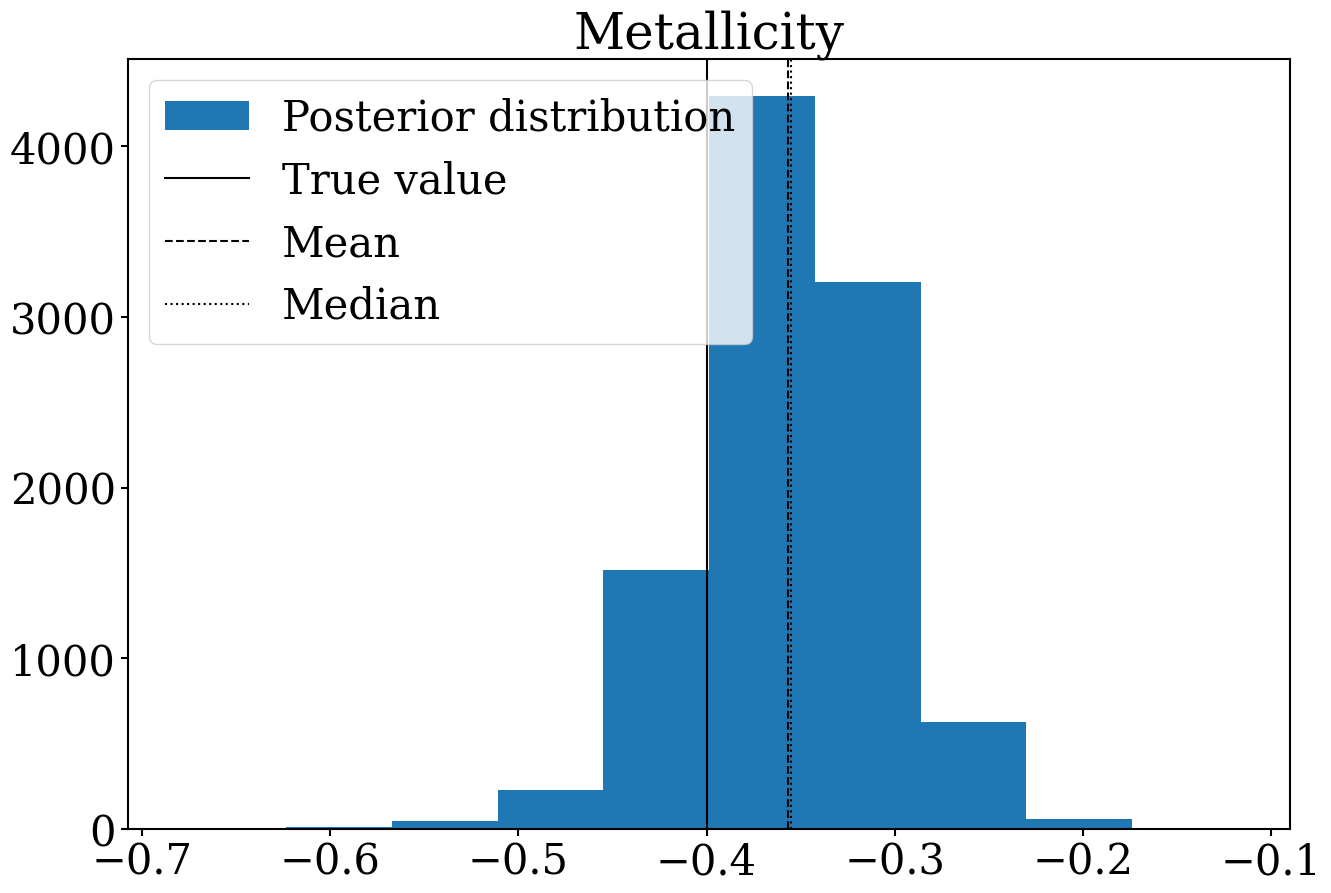

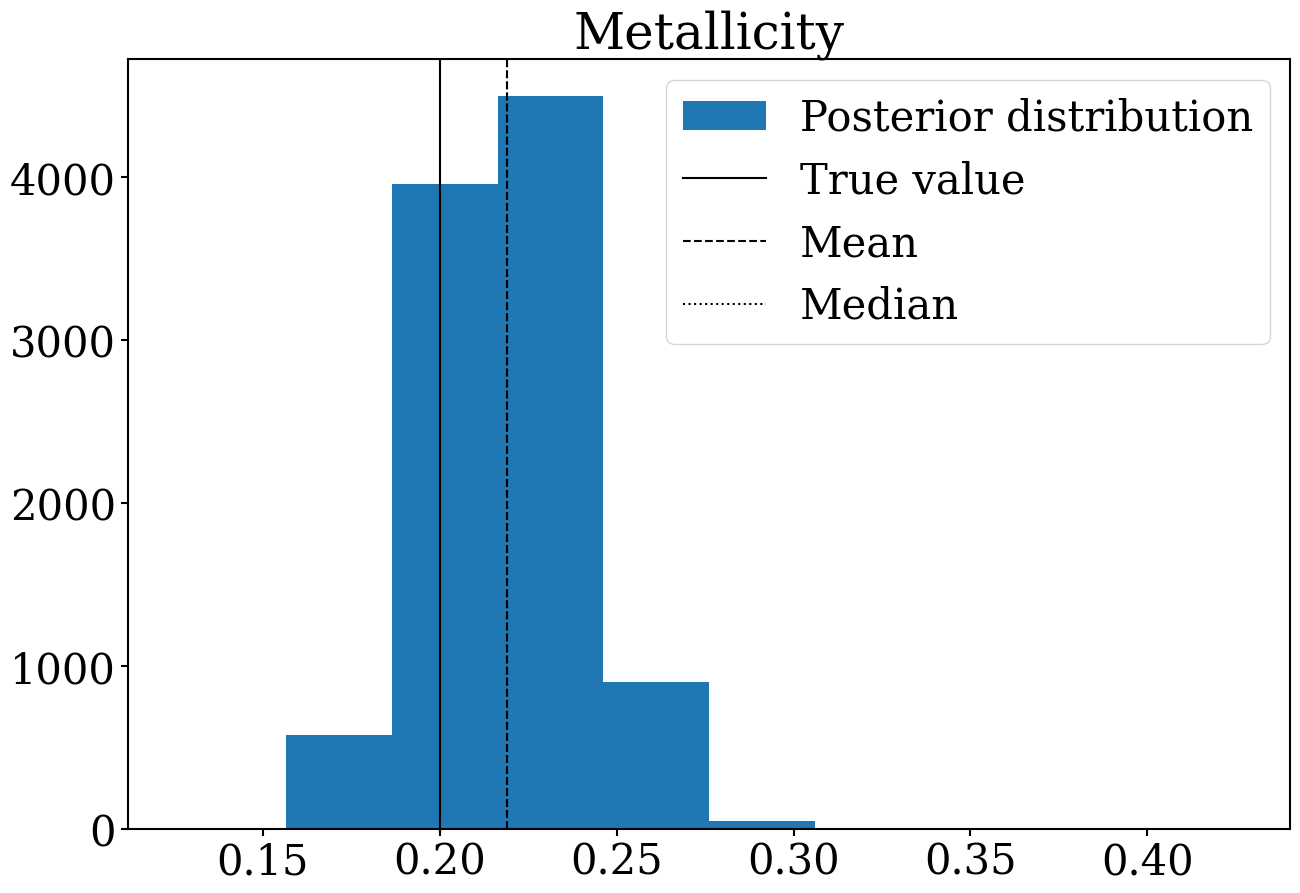

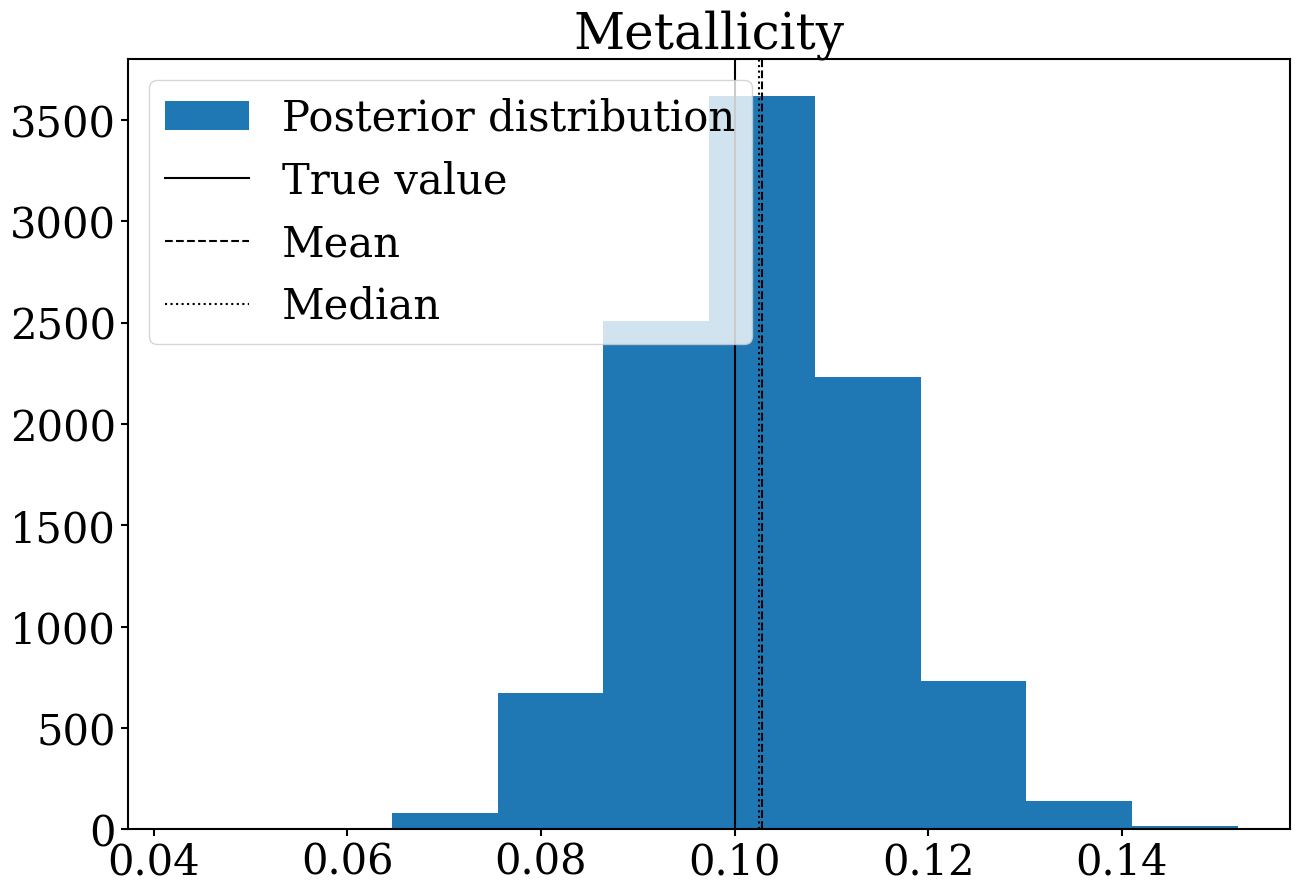

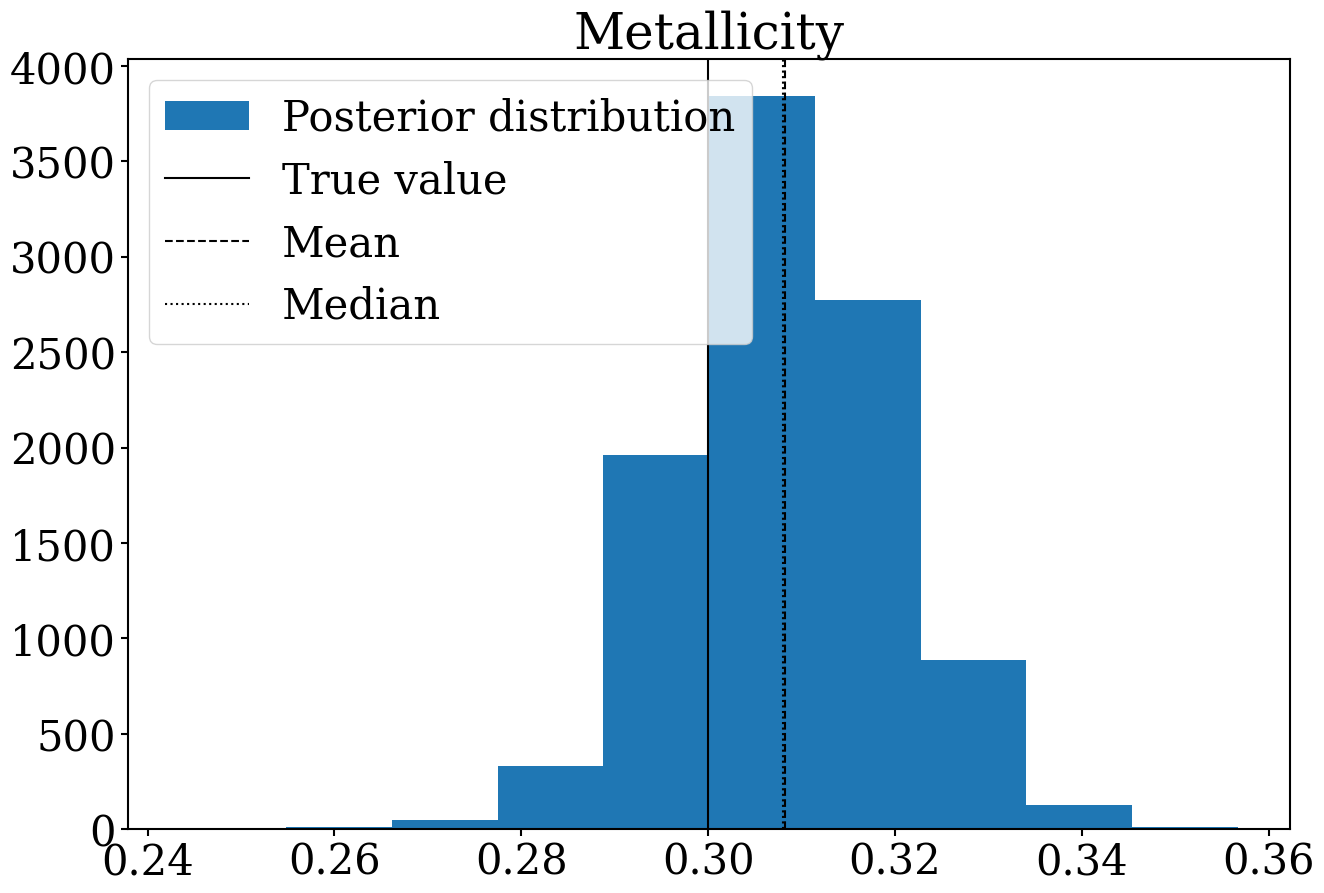

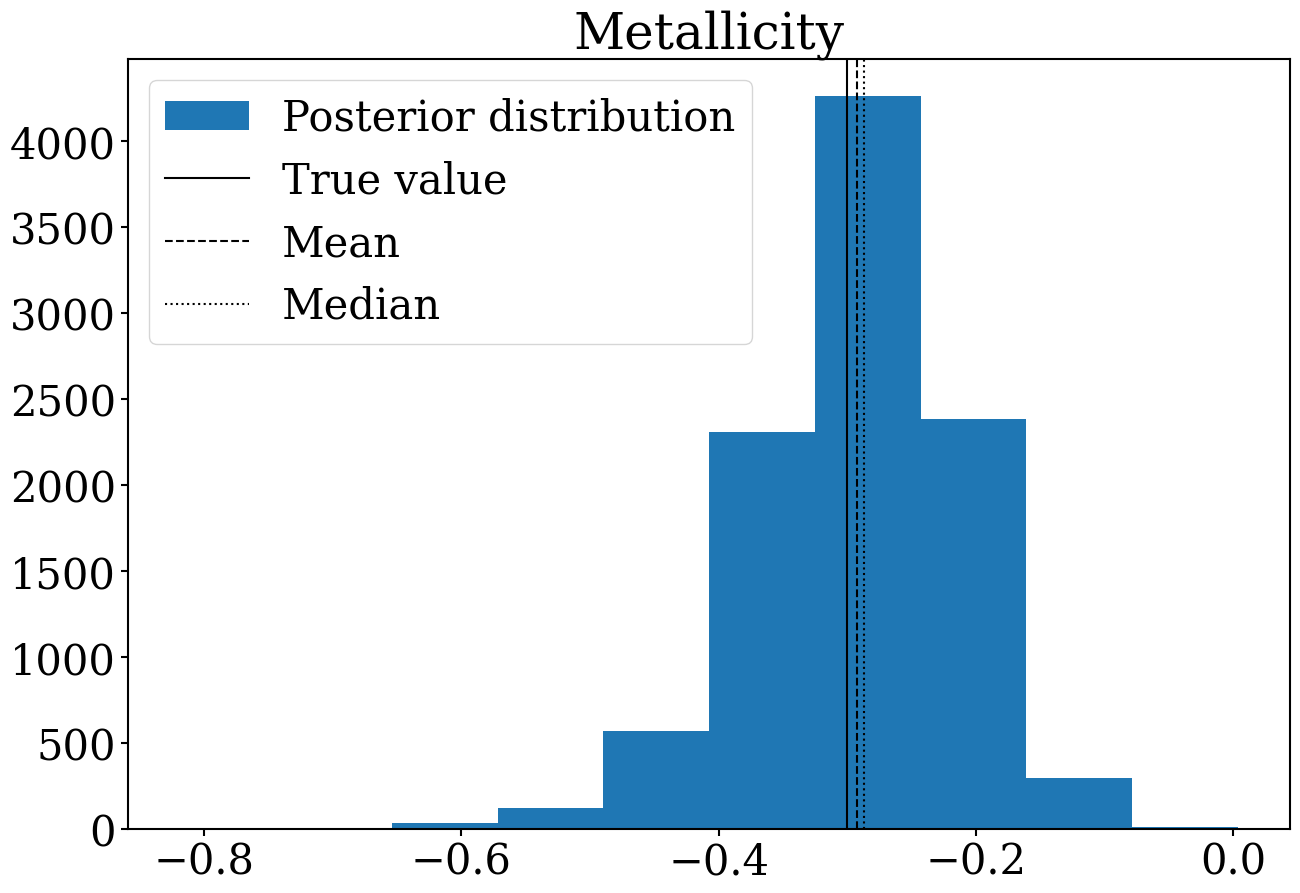

In [12]:
index_list=np.random.randint(81000,90000,5)

for k,j in enumerate(index_list):
                Xobs=latents[j,:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,-1],label='Posterior distribution')
                plt.axvline(percentiles[j,-1],ls='-',c='k',label='True value')
                plt.axvline(np.mean(posterior_samples[:,-1]),ls='--',c='k',label='Mean')
                plt.axvline(np.median(posterior_samples[:,-1]),ls=':',c='k',label='Median')
                plt.title('Metallicity')
                plt.legend()
                plt.show()

               

Compute the median of the posterior distributions predicted for the test sample (for each feature)

In [14]:
n_evaluations=90000 #size of the test sample
n_samples=1000 #number of evaluations of the posterior
index_list=np.arange(81000,90000) #list indeces of test sample in the previously shuffled full dataset

stds=[]
means=[]

for k,j in tqdm(enumerate(index_list)): #one galaxy at a time
    Xobs=latents[j,:]
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))  #sample the posteriors for each galaxy
    stds.append(np.std(posterior_samples,axis=0))   #save in the list an array with std of each feature
    means.append(np.median(posterior_samples,axis=0)) #save in the list an array with median of each feature
    
#Save medians and standard deviations for the test set and the 10 features predicted
np.save('./saved_models/means_etg.npy',means)
np.save('./saved_models/stds_etg.npy',stds)

9000it [3:34:53,  1.43s/it]  


Using the medians and comparing them with the true values for the features to estimate, compute accuracies for each feature in the test sample.

In [28]:
#COMPUTE ACCURACY

index_list=np.arange(81000,90000)
means=np.load('./saved_models/means_etg.npy')
stds=np.load('./saved_models/stds_etg.npy')

accuracy=[]
for i in range(10):
    if i<9:
        p0=np.where(percentiles[index_list,i]>1e-1)[0]
        accuracy.append(100-np.mean(np.abs(means[:,i][p0]-percentiles[index_list,i][p0])/np.abs(percentiles[index_list,i][p0]) * 100))
    else:
        accuracy.append(100-np.mean(np.abs(means[:,i]-percentiles[index_list,i])/np.abs(percentiles[index_list,i]) * 100))

#notice this is MAPE np.mean(np.abs(means[:,i]-percentiles[index_list,i])/np.abs(percentiles[index_list,i]) * 100)

print(np.around(accuracy,decimals=2))

[62.84 71.92 79.17 85.31 89.22 93.45 95.63 97.34 98.77  -inf]


/var/folders/26/90klcxjd1_x9q0l8mz3tx1g00000gn/T/ipykernel_17426/1937369310.py:13: RuntimeWarning: divide by zero encountered in divide
  accuracy.append(100-np.mean(np.abs(means[:,i]-percentiles[index_list,i])/np.abs(percentiles[index_list,i]) * 100))


In [31]:



import sklearn.metrics as sm
for i in range(10):

    print('i = ' , i)
    y_test_pred=means[:,i]
    y_test=percentiles[index_list,i]

    print( "Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2) )
    print( "Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2) )
    print( "Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2) )
    print( "Explained variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2) )
    print( "R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))





i =  0
Mean absolute error = 0.58
Mean squared error = 0.96
Median absolute error = 0.28
Explained variance score = 0.77
R2 score = 0.76
i =  1
Mean absolute error = 0.58
Mean squared error = 0.93
Median absolute error = 0.29
Explained variance score = 0.86
R2 score = 0.86
i =  2
Mean absolute error = 0.45
Mean squared error = 0.65
Median absolute error = 0.22
Explained variance score = 0.93
R2 score = 0.93
i =  3
Mean absolute error = 0.4
Mean squared error = 0.53
Median absolute error = 0.19
Explained variance score = 0.95
R2 score = 0.95
i =  4
Mean absolute error = 0.39
Mean squared error = 0.59
Median absolute error = 0.16
Explained variance score = 0.95
R2 score = 0.95
i =  5
Mean absolute error = 0.28
Mean squared error = 0.39
Median absolute error = 0.1
Explained variance score = 0.96
R2 score = 0.96
i =  6
Mean absolute error = 0.23
Mean squared error = 0.33
Median absolute error = 0.07
Explained variance score = 0.96
R2 score = 0.96
i =  7
Mean absolute error = 0.17
Mean squa

Plot medians of the posterior distributions estimated for the percentiles and [M/H], compared to the true values. The accuracy achieved for each prediction is shown. Each blue dot is a different sample from the test set. The red line shows the one-to-one relation, the histograms at the right of each panel show the marginal distributions of the predictions, and the histograms of the real data are shown at the top. Kernel Density Estimation (KDE) contours are drawn in black at iso-proportions of the density of samples.

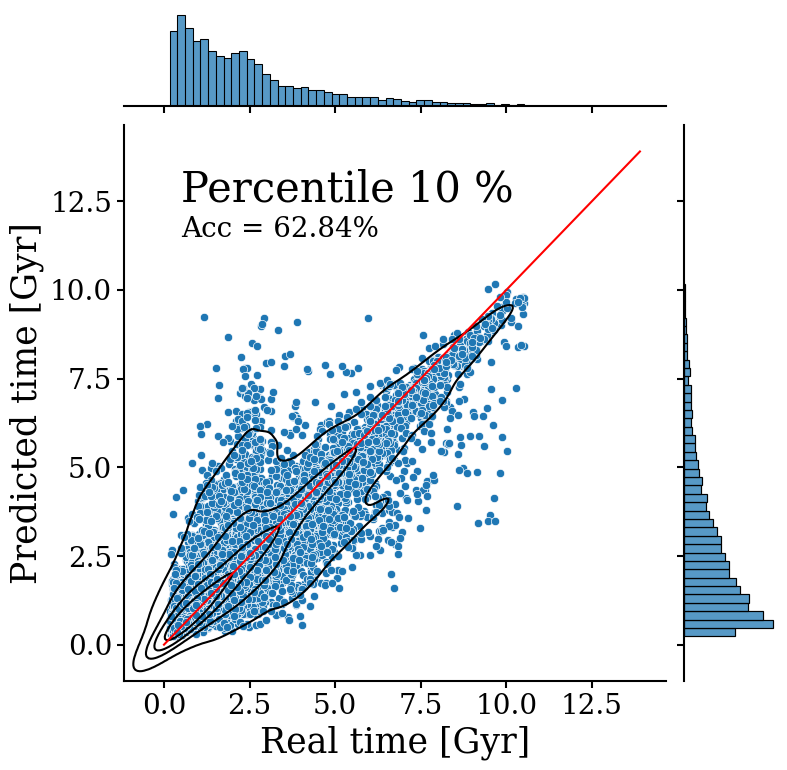

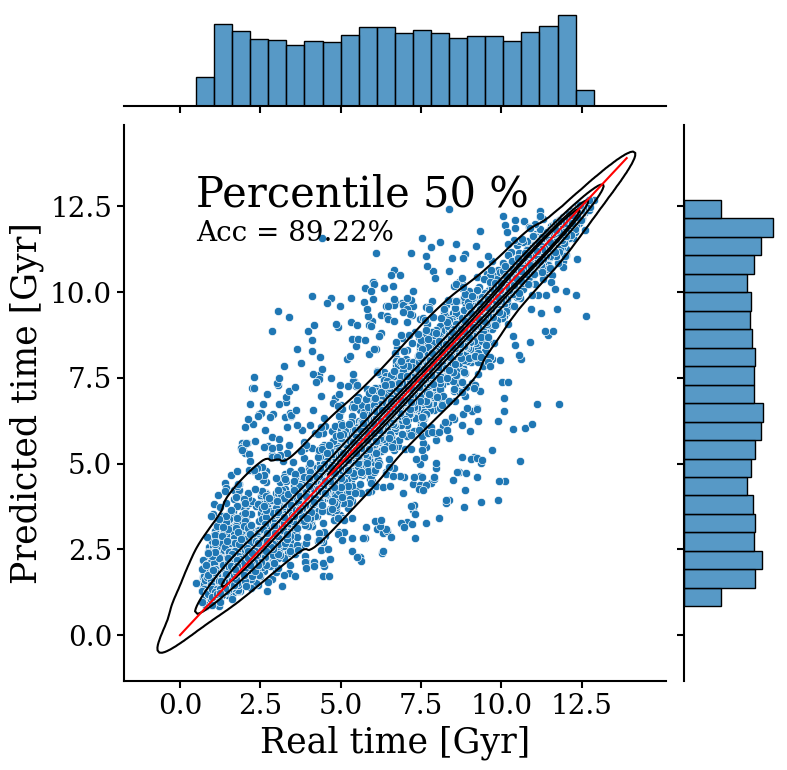

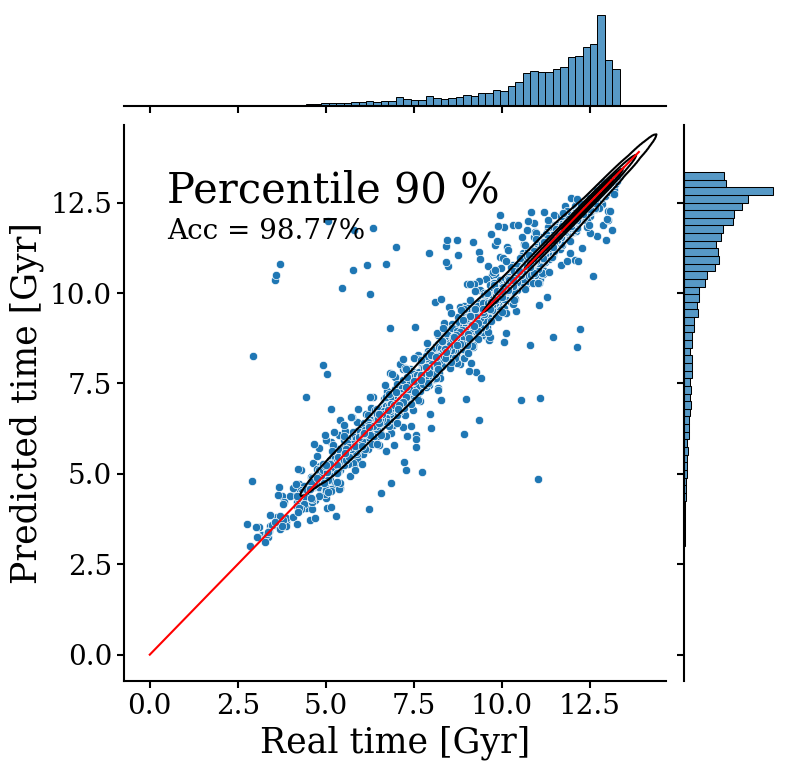

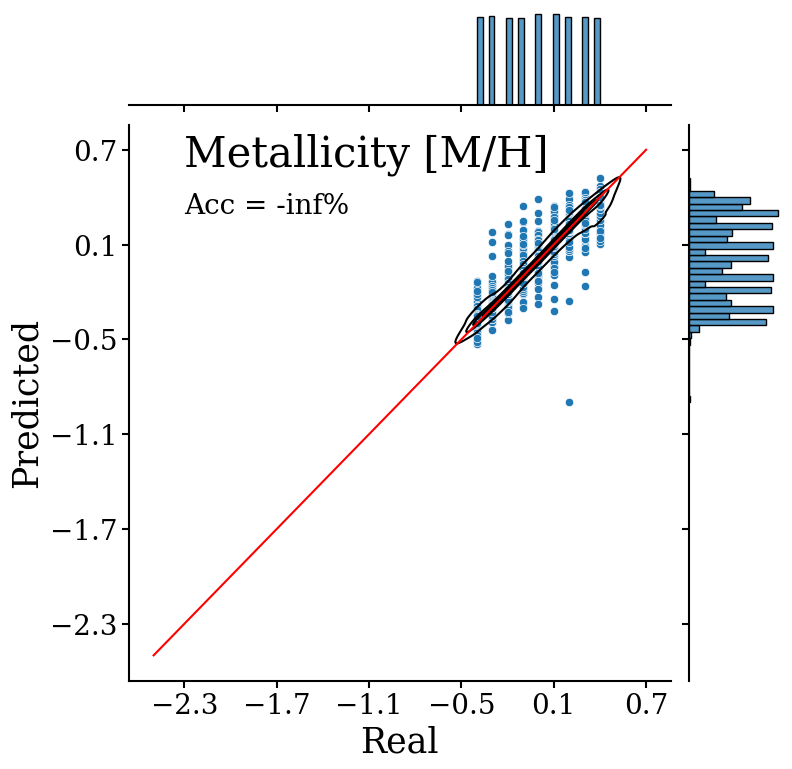

In [19]:
index_list=np.arange(135000,150000)
means=np.load('./saved_models/means_etg.npy') #change if needed
stds=np.load('./saved_models/stds_etg.npy')

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


import seaborn as sns

for i in [0,4,8,9]:
    
    p=percentiles[index_list,i]

    if i<9:
        g=sns.jointplot(x=p, y=means[:,i],height=8,label='Test data',legend=False)#kind='reg')
        x=np.arange(0,14,0.1)
        kde=g.plot_joint(sns.kdeplot, color="k", zorder=1, levels=5,label='KDE')
        d=g.ax_joint.plot(x, x, '-r',label='y=x')

        g.set_axis_labels('Real time [Gyr]','Predicted time [Gyr]',fontsize=25)
        g.ax_joint.set_xticks(np.arange(0,15,2.5))
        g.ax_joint.set_yticks(np.arange(0,15,2.5))
        g.ax_joint.text(0.5,12.5,'Percentile '+str((i+1)*10)+' %',fontsize=30)
        g.ax_joint.text(0.5,11.5,'Acc = '+str(np.around(accuracy[i],2))+'%',fontsize=20)
        
    
    elif i==9:
        g=sns.jointplot(x=p, y=means[:,i],height=8,label='Test',legend=False)#,kind='kde')
        kde=g.plot_joint(sns.kdeplot, color="k", zorder=1, levels=5, label='KDE')
        x=np.arange(-2.5,0.8,0.1)
        d=g.ax_joint.plot(x, x, '-r',label='y=x')
        g.set_axis_labels('Real',
        'Predicted',fontsize=25)
        g.ax_joint.set_xticks([-2.3,-1.7,-1.1,-0.5,0.1,0.7])
        g.ax_joint.set_yticks([-2.3,-1.7,-1.1,-0.5,0.1,0.7])
        g.ax_joint.text(-2.3,0.6,'Metallicity [M/H]',fontsize=30)
        g.ax_joint.text(-2.3,0.3, 'Acc = '+str(np.around(accuracy[i],2))+'%',fontsize=20)
    #g.savefig('sns_mean_true_kde_6_'+str(i)+'.jpg')
    plt.show()